# Tecniche di Fitting

Si è generato un campione di $NSignal = 2000$ eventi di segnale distribuiti secondo una Breit Wigner con $FWHM = 149\, MeV$ e $M_0 = 776\, MeV$. 

A ciò si è sovrapposto un fondo polinomiale di secondo ordine di $NBKG = 5000$ eventi tra 0 e $1500\,MeV$.

Infine, ad ogni punto generato si è applicato un noise gaussiano con risoluzione $NoiseRes = 10\, MeV$.

Si è quindi proceduto ad eseguire il fit dei dati utilizzando le tecniche di Extended Maximum Likelihood, (Binned) Maximum Likelihood, Least Squares e Modified Least Squares.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.optimize as opt
import scipy.integrate as integrate
import numbers


# Parametri Breit-Wigner
NSignal=2000
M0=776.
FWHM=149.

# Parametri fondo
NBKG=5000

# Parametri noise
NoiseMean = 0
NoiseRes = 10

np.random.seed(1)  #Inizializzo il seed

Ntot = NSignal + NBKG   # Calcolo il logaritmo degli eventi totali misurati
logNtot = math.log(Ntot)


Definisco la distribuzione di probabilità somma delle due distribuzioni moltiplicate per il parametro indicante il numero di eventi di ciascun tipo:
$$
\mbox{Eventi Attesi }(x,\vec{\theta}) = \quad n_{signal}\frac{1}{\pi} \frac{\Gamma/2}{\Gamma^2/2 + (x - M_0)^2} \quad + \quad n_{background} \frac{3}{x_{max}^3} x^2
$$

In [2]:
def Distribuzione(x, parametri):
        n_sig = parametri[0]    # scompongo il vettore "parametri" nei singoli parametri per dargli senso fisico
        M_0 = parametri[1]
        Gamma = parametri[2]
        n_back = parametri[3]
        x_max = 1500.

        ### numero eventi come parametro
        EventiAttesi = 1.*n_sig/math.pi * (Gamma/2.)/((Gamma/2.)**2 + (x-M_0)**2) + n_back * 3./(x_max)**3 * (x)**2
        ### numero eventi fissati
#        EventiAttesi = 2000./math.pi * (Gamma/2.)/((Gamma/2.)**2 + (x-M_0)**2) + 5000. * 3./(x_max)**3 * (x)**2         # eventi fissati

        if isinstance(EventiAttesi, numbers.Real):  # Questa if clause è per assicurarmi che l'output del conto sia 
                                                    # un numero reale e non una lista
                if      float(EventiAttesi) <= 0:   # Se il numero di eventi attesi è negativo lo fisso a
                        return 1e-3                 # un numero piccolo
                else:
                        return EventiAttesi
        else:
                return EventiAttesi
#       2000/math.pi * (Gamma/2.)/((Gamma/2.)**2 + (x-M_0)**2) + 5000 * 3./(x_max)**3 * (x)**2          #N segnale e N background fissati



Definisco la *Extended Likelihood* come una Likelihood in cui la normalizzazione è assunta come una variabile poissoniana:
$$ ExtLikelihood (\vec{x}, \vec{\theta}, \nu) = \frac{e^{-\nu}\nu^{n}}{n!} \prod_i^n f(x_i,\vec{\theta})$$

Il metodo della *Extended Maximum Likelihood* si basa sulla massimizzazione di questa funzione (o del suo logaritmo, per semplicità) per la stima dei parametri. La funzione da massimizzare è quindi:
$$l_E = \sum_i^n \log (\nu f(x,\vec{\theta})) - \nu$$

In [3]:
def ExtendedLogLikelihood (parametriExtended):

        ELogLikelihood = 0
        # Scompongo il vettore dei parametri in input alla funzione in un vettore di parametri necessari
        # alla funzione Distribuzione e nel parametro che rappresenta nu (parametriExtended[4])
        parametri = [parametriExtended[0], parametriExtended[1], parametriExtended[2], parametriExtended[3]]

        for i, x in enumerate(signalback):        #La lista signalback conterrà segnale e fondo
                Termine_somma = math.log(parametriExtended[4] * Distribuzione(x,parametri) / Ntot)
                ELogLikelihood +=  Termine_somma
        ELogLikelihood -= parametriExtended[4]
        return -1. * ELogLikelihood   # Cambio segno per poter usare un algoritmo di minimizzazione nel programma
    

Definisco ora la funzione Binned Likelihood, utilizzata al posto della Likelihood poichè gli eventi saranno, appunto, binnati.
La Binned Likelihood consiste nell'applicazione di una pdf multinomiale per il calcolo delle probabilità di avere un determinato numero di eventi in ogni bin. Avendo $k$ bin e $n_tot$ eventi misurati, si ha:
$$BinnedLikelihood = n_{tot}! \prod_i^k \frac{\nu_i}{n_{tot}n_i!} $$
con:
$$\nu_i = n_{tot} \int_{bin_i} f(x,\vec{\theta}) dx$$
che rappresenta il numero di eventi attesi nel bin i-esimo.

La funzione da massimizzare diventa quindi:
$$l = \sum_i^k n_i\,\log(\frac{\nu_i}{n_{tot}})$$
con $n_i$ eventi nello i-esimo bin.

In [4]:
def LogLikelihood (parametri):

        BLogLikelihood = 0

        for i in range(len(conteggi)):   #La lista conteggi contiene il numero di eventi in ciascun bin
                x = (bin[i] + bin[i+1])/2.    # Definisco la x su cui ...?
                
                # Calcolo il valore nu ed il suo errore, che poi non utilizzerò
                nu, errnu = integrate.quad(Distribuzione,  bin[i], bin[i+1], args=(parametri))

                # Con questa if clause setto un tetto al valore massimo che può assumere il logaritmo
                if (nu < 1e-5): 

                        if conteggi[i] == 0:  # Se i conteggi nel bin sono zero, non aggiungo nulla
                                continue
                        else:                 # Setto il tetto massimo al logaritmo
                                BLogLikelihood += conteggi[i] * ( (-1e3) - logNtot)
                else:                         # Altrimenti aggiungo il valore calcolato
                        BLogLikelihood += conteggi[i] * (math.log(nu) - logNtot)

        return -1.*BLogLikelihood    # Cambio segno per poter usare un algoritmo di minimizzazione nel programma


Definisco quindi le funzioni per i metodi Least Squares e Modified Least Squares. In questi metodi si minimizza la funzione:
$$\chi^2(\vec{\theta}) = \sum_i^k \frac{\left( n_i - \nu_i\,(\vec{\theta}) \right)^2}{\sigma_i^2}$$
Dove nel caso LS:
$$\sigma_i^2 = \nu_i\,(\vec{\theta})$$
mentre nel caso MLS:
$$\sigma_i^2 = n_i$$
con $n_i$ numero di eventi nel bin i-esimo e $\nu_i$ definita come nel caso precedente.

In [5]:
def LeastSquares (parametri):

        LS = 0
        for i in range(len(conteggi)):
                x = (bin[i] + bin[i+1])/2.
                
                # Calcolo il valore nu ed il suo errore, che poi non utilizzerò
                nu, errnu = integrate.quad(Distribuzione,  bin[i], bin[i+1], args=(parametri))
                if nu == 0:
                        LS += (conteggi[i] - nu)**2 / 1e-3
                else:
                        LS += (conteggi[i] - nu)**2 / nu

        return LS


def ModLeastSquares (parametri):

        MLS = 0
        for i in range(len(conteggi)):
                x = (bin[i] + bin[i+1])/2.
                 
                # Calcolo il valore nu ed il suo errore, che poi non utilizzerò
                nu, errnu = integrate.quad(Distribuzione,  bin[i], bin[i+1], args=(parametri))

                if conteggi[i] == 0:     # Se il numero di conteggi in un bin è nullo divido per un numero
                                         # arbitrario piccolo
                        MLS += (conteggi[i] - nu)**2 / 0.01
                else:
                        MLS += (conteggi[i] - nu)**2 / (1.*conteggi[i])

        return MLS


Genero gli eventi di segnale utilizzando il metodo della funzione inversa che per una Breit Wigner significa ottenere le variabili tramite la funzione:
$$\mbox{result} = M_0 + \frac{\Gamma}{2} \tan(x)$$
con $x$ variabile random distribuita uniformemente in $[-\frac{\pi}{2}, \frac{\pi}{2}]$.

In [6]:
print("Genero gli eventi...")
signal = []     #creo la lista dove immagazzino il segnale

while len(signal) < NSignal:    #Mi assicuro di avere NSignal eventi, dato che scarterò quelli negativi 
                                # e quelli oltre la x massima considerata
        
        result = M0 + (FWHM/2) * math.tan(np.random.uniform(-math.pi/2.,+math.pi/2.))
        if result > 0:                  #Impongo il vincolo che sia positivo, altrimenti non è fisico.
                if result < 1500:       #Questo vincolo serve per non prendere segnale olte la xMax.
                        noise = np.random.normal(NoiseMean, NoiseRes)   #Genero il noise gaussiano
                        signal.append(result + noise)   #Immagazzino il dato



Genero gli eventi...


Genero gli eventi di fondo utilizzando ancora il metodo della funzione inversa. Per un polinomio di secondo ordine si ha:
$$\mbox{result} = x_{max} \sqrt[3]{x}$$
con $x$ variabile random distribuita uniformemente in $[0,1]$.

In [7]:
signalback = signal     # Creo la lista dove immagazzinerò segnale e fondo e la riempio col segnale
x_max = 1500.

for i in range(NBKG):
        result = x_max * (np.random.uniform(0.,1.))**(1/3.) # Genero il fondo
        noise = np.random.normal(NoiseMean, NoiseRes)       # Genero il noise gaussiano
        signalback.append(result + noise)


Istogrammo gli eventi ed estraggo dallo stesso i dati riguardanti i conteggi e i bin. Calcolo il numero di eventi totali.

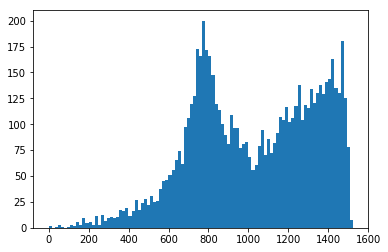

In [8]:
# Istogrammo gli eventi
bin = np.linspace(min(signalback), max(signalback),100) # Creo bin dal segnale minimo al segnale massimo.
Histogram = plt.hist(signalback,bin, label='Dati')

conteggi, bin, bars = Histogram # Estraggo i  dati dall'istogramma

# Calcolo i conteggi totali nell'istogramma che so già coincidere con i 7000 desiderati
conteggi_totali = 0
for i in range(len(conteggi)):
        conteggi_totali += conteggi[i]

Procedo quindi a fare il fitting dei dati.
Inizializzo i parametri. La lista *parametriExtended* contiene in più anche il valore iniziale del parametro $\nu$ della Extended Likelihood.

La funzione di minimizzazione *scipy.optimize.minimize* permette la minimizzazione con vincoli. Definisco quindi il vincolo che:
$$n_{tot} - n_{signal} - n_{background} = 0$$
Posso poi decidere se utilizzarlo o meno commentando la riga di codice corrispondente.

Fit EML... 
Fit ML... 
Fit LS... 
Fit MLS... 


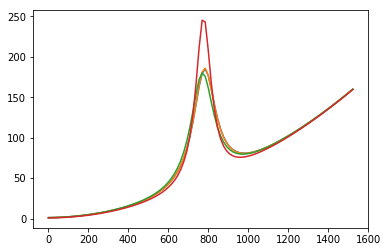

In [9]:
parametri = [2e3, 1e3, 1e2, 5e3]    # n_signal, FWHM, M_0, n_background
parametriExtended = [2e3, 1e3, 1e2, 5e3, 7e3]

cons = ({'type': 'eq', 'fun': lambda x: conteggi_totali - x[0] - x[3]}) 



### Extended Maximum Likelihood
print("Fit EML... ")

### Eseguo il fit minimizzando la funzione con scipy.optimize.minimize()
result = opt.minimize(ExtendedLogLikelihood, parametriExtended, tol=1)                          #Senza vincolo
#result = opt.minimize(ExtendedLogLikelihood, parametriExtended, tol=1, constraints=cons)       #Con vincolo

if result.success:
        parametri_EML = result.x                 # Se il fit converge, estraggo i parametri ricavati
else:
        raise ValueError(result.message)
        
#Genero una x per ogni bin così da graficare la funzione con i parametri appena ottenuti
xgraph = np.linspace (0, max(bin), len(bin))

# Plotto il grafico, compenso la discretizzazione dell'istogramma moltiplicando
# il valore in un punto della funzione per la larghezza dei bin.
fitfunEML = plt.plot(xgraph, (bin[1]-bin[0])*Distribuzione(xgraph,parametri_EML), label='EML')  






### Binned Maximum Likelihood
print("Fit ML... ")

result = opt.minimize(LogLikelihood, parametri, tol=1)                         #Senza vincolo
#result = opt.minimize(LogLikelihood, parametri, tol=1, constraints=cons)        #Con vincolo

if result.success:
        parametri_ML = result.x
else:
        raise ValueError(result.message)
        
#Plotto il grafico, con le stesse x del precedente.
fitfunML = plt.plot(xgraph, (bin[1]-bin[0])*Distribuzione(xgraph,parametri_ML), label='ML')    



### Least Squares
print("Fit LS... ")

result = opt.minimize(LeastSquares, parametri, tol=1)                           #Senza vincolo
#result = opt.minimize(LeastSquares, parametri, tol=1, constraints=cons)                #Con vincolo

if result.success:
        parametri_LS = result.x
else:
        raise ValueError(result.message)

        
fitfunLS = plt.plot(xgraph, (bin[1]-bin[0])*Distribuzione(xgraph,parametri_LS), label='LS')   #Plotto il grafico.






### Modified Least Squares
print("Fit MLS... ")

result = opt.minimize(ModLeastSquares, parametri, tol=1)                        #Senza vincolo
#result = opt.minimize(ModLeastSquares, parametri, tol=1, constraints=cons)       #Con vincolo

if result.success:
        parametri_MLS = result.x
else:
        raise ValueError(result.message)

#Plotto il grafico. 
fitfunMLS = plt.plot(xgraph, (bin[1]-bin[0])*Distribuzione(xgraph,parametri_MLS), label='MLS')  


Proseguo quindi con il calcolo delle incertezze sui parametri stimati.
Per le tecniche legate alla Maximum Likelihood, assumendo una distribuzione degli errori gaussiana, ho che nei pressi del minimo vale:
$$\log L(\theta) = \log L(\hat{\theta}) - \frac{(\theta- \hat{\theta})^2}{2\sigma_{\hat{\theta}}^2}$$
E quindi:
$$\log(L(\hat{\theta}) \pm \sigma_{\hat{\theta}}) = \log (L(\hat{\theta})) - \frac{1}{2}$$



Per quanto riguarda le tecniche LS e MLS si noti che per errori gaussiani:
$$\log(L) =  \frac{(x - \mu)^2}{2\sigma^2} = - \frac{1}{2} \chi^2$$
e quindi si possono calcolare le incertezze sul parametro calcolato come:
$$\chi^2(\hat{\theta} \pm \sigma_{\hat{\theta}}) = \chi^2(\hat{\theta}) + 1$$

In [10]:
print("Calcolo le incertezze...")
# Definisco una variabile globale "parametro" che andrà da 0 a 3 (i 4 parametri della distribuzione)
# Tramite un ciclo for, per ciascun valore di quest'ultima, uso la funzione scipy.optimize.root()
# che mi calcola lo zero della funzione di una variabile che ha in input.
# Per questo motivo definisco 4 funzioni (onevarEML, onevarML, etc..) che rendono una funzione
# "di un solo parametro" le funzioni "di molti parametri" definite all'inizio del programma.


# Creo delle copie delle liste contenenti i parametri ricavati tramite fit.
# Andrò a variare i valori contenuti nelle liste "theta" mentre quelle "parametri"
# resteranno fisse.
theta_EML = parametri_EML.copy()
theta_ML = parametri_ML.copy()
theta_LS = parametri_LS.copy()
theta_MLS = parametri_MLS.copy()

global parametro        # Definisco la variabile globale

# Definisco le 4 liste contenenti le incertezze.
Incertezza_EML = []
Incertezza_ML = []
Incertezza_LS = []
Incertezza_MLS = []

def onevarEML(x):
        global parametro
        theta_EML[parametro]=x
        return -1.*ExtendedLogLikelihood(parametri_EML) -0.5 - -1.*ExtendedLogLikelihood(theta_EML)

def onevarML(x):
        global parametro
        theta_ML[parametro]=x
        return -1.*LogLikelihood(parametri_ML) -0.5 - -1.*LogLikelihood(theta_ML)

def onevarLS(x):
        global parametro
        theta_LS[parametro]=x
        return LeastSquares(parametri_LS) -1. - LeastSquares(theta_LS)

def onevarMLS(x):
        global parametro
        theta_MLS[parametro]=x
        return ModLeastSquares(parametri_MLS) -1. - ModLeastSquares(theta_MLS)

# Eseguo il calcolo facendo un ciclo for sui 4 parametri di interesse
# Ottenuto lo zero della funzione calcolo l'incertezza del parametro tramite distanza dal valore stimato
# e lo inserisco nella lista delle incertezze
for parametro in range(len(parametri_ML)):
        Incertezza_EML.append(abs(parametri_EML[parametro] - float(opt.root(onevarEML, parametri[parametro], method='hybr', tol=1e-3).x) ))
        Incertezza_ML.append(abs(parametri_ML[parametro] - float(opt.root(onevarML, parametri[parametro], method='hybr', tol=1e-3).x) ))
        Incertezza_LS.append(abs(parametri_LS[parametro] - float(opt.root(onevarLS, parametri[parametro], method='hybr', tol=1e-3).x) ))
        Incertezza_MLS.append(abs(parametri_MLS[parametro] - float(opt.root(onevarMLS, parametri[parametro], method='hybr', tol=1e-3).x) ))




Calcolo le incertezze...


I parametri sono NSignal, M0, FWHM, NBackground.
Ext. Maximum Likelihood:  			Binned Maximum Likelihood:  			Least Squares:  			Modified Least Squares
2000.0  +-  0.0 	 2000.0  +-  0.0 	 2000.0  +-  0.0 	 2000.0  +-  0.0
781.0890760876392  +-  16.272057636817067 	 780.3407326135912  +-  15.42619476708262 	 769.8967285221863  +-  2.7672979231919044 	 775.6623139860369  +-  0.7900673235176328
136.7672062514163  +-  37.99554973072925 	 135.63442920672605  +-  37.27473375210461 	 140.27003782841007  +-  0.14364359408668292 	 93.9931969022162  +-  0.49639175975519834
5000.0  +-  0.0 	 5000.0  +-  0.0 	 5000.0  +-  0.0 	 5000.0  +-  0.0

nu EML:  6999.99650360165


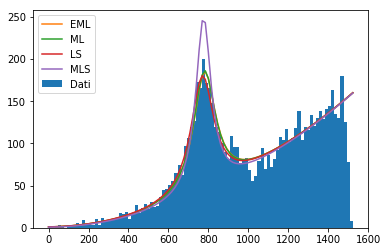

In [11]:
# Stampo a schermo i risultati
print("I parametri sono NSignal, M0, FWHM, NBackground.")
print("Ext. Maximum Likelihood: ","\t\t\tBinned Maximum Likelihood: ","\t\t\tLeast Squares: ","\t\t\tModified Least Squares")
for i in range(len(parametri_ML)):
        print(parametri_EML[i]," +- ", Incertezza_EML[i],"\t", parametri_ML[i], " +- ", Incertezza_ML[i], "\t", parametri_LS[i], " +- ", Incertezza_LS[i], "\t", parametri_MLS[i], " +- ",Incertezza_MLS[i])

print("\nnu EML: ", parametri_EML[4])


# Plotto i grafici
Histogram = plt.hist(signalback,bin, label='Dati')
fitfunEML = plt.plot(xgraph, (bin[1]-bin[0])*Distribuzione(xgraph,parametri_EML), label='EML')  
fitfunML = plt.plot(xgraph, (bin[1]-bin[0])*Distribuzione(xgraph,parametri_ML), label='ML')    
fitfunLS = plt.plot(xgraph, (bin[1]-bin[0])*Distribuzione(xgraph,parametri_LS), label='LS') 
fitfunMLS = plt.plot(xgraph, (bin[1]-bin[0])*Distribuzione(xgraph,parametri_MLS), label='MLS')  


plt.legend()
plt.show()



# Risultati fit eventi liberi - senza vincolo:



![title](./SegnaleLiberoNoVincoloSeed1.png)




Si osserva come i risultati siano approssimativamente giusti, tuttavia sono in pochi ad essere compatibili con i valori esatti entro le incertezze statistiche.
Il metodo che restituisce i risultati più soddisfacenti è quello Least Squares, che comprende i valori veri degli eventi di segnale e fondo entro le incertezze statistiche.
Il metodo Binned Maximum Likelihood contiene il valore vero per $M_0$ ma restituisce solamente risultati approssimativi negli altri casi.

# Risultati fit eventi liberi - con vincolo:

![title](./SegnaleLiberoVincoloSeed1.png)

Anche in questo caso i risultati più soddisfacenti sono restituiti dalla tecnica Least Squares. Tutte le tecniche Least Squares restituiscono un valore di $M_0$ compatibile con l'incertezza, mentre quelle Maximum Likelihood lo avvicinano solamente.
Solamente il metodo Least Squares restituisce un valore soddisfacente del parametro FWHM.

# Risultati fit eventi fissati:

![title](./SegnaleFissatoSeed1.png)

Fissando il numero di eventi di segnale e fondo, invece, si ottengono dei risultati compatibili entro l'incertezza per i metodi Maximum Likelihood.
Per MLS si ha $M_0$ compatibile e FWHM no, mentre per LS si ha $M_0$ molto vicina al valore vero ma non entro l'incertezza, e una FWHM del giusto ordine di grandezza ma non compatibile a causa di una incertezza molto ridotta.

I risultati maggiormente soddisfacenti nel caso dei numeri di eventi fissati sono attribuibili alla riduzione dei gradi di libertà del problema. 